In [5]:
from google.colab import files
uploaded = files.upload()

Saving oilspill_model_weights.pth to oilspill_model_weights.pth


In [6]:
import os
print(os.listdir())


['.config', 'model.pth', '.ipynb_checkpoints', 'sample_data']


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OilSpillCNN(nn.Module):
    def __init__(self):
        super(OilSpillCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)     # TWO OUTPUT CLASSES
        )

    def forward(self, x):
        return self.net(x)


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = OilSpillCNN().to(device)

state_dict = torch.load("model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

model.eval()

print("✔ Model loaded successfully")


✔ Model loaded successfully


In [14]:
from PIL import Image
from torchvision import transforms

transform_sar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [15]:
import numpy as np

def predict_sar_image(path):
    img = Image.open(path).convert("L")
    img = transform_sar(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)[0].cpu().numpy()

    pred_class = np.argmax(probs)
    confidence = probs[pred_class] * 100

    label = "NO OIL SPILL" if pred_class == 0 else "OIL SPILL DETECTED"

    print(f"\nImage: {path}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.2f}%")

    return label, confidence


In [17]:
predict_sar_image("/content/0_0_0_img_c7AEvXurNDyqNJ0n_GBR_cls_1.jpg")


Image: /content/0_0_0_img_c7AEvXurNDyqNJ0n_GBR_cls_1.jpg
Prediction: OIL SPILL DETECTED
Confidence: 66.81%


('OIL SPILL DETECTED', np.float32(66.8081))

In [18]:
!pip install requests pillow numpy


In [19]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

CLIENT_ID = "55028041-25e0-419f-9bae-041fc678230e"
CLIENT_SECRET = "UlBJzsPCPfowmE7EBFdNkm5GR27v1OO5"

def get_token():
    client = BackendApplicationClient(client_id=CLIENT_ID)
    oauth = OAuth2Session(client=client)

    token = oauth.fetch_token(
        token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
        client_secret=CLIENT_SECRET,
        include_client_id=True
    )
    return token['access_token']

token = get_token()
print("TOKEN RECEIVED ✔")


TOKEN RECEIVED ✔


In [20]:
import requests

INSTANCE_ID = "bc51ee76-0257-45d7-a9a5-b9745e875aaa"
LAYER_ID = "API"

def download_sar_tile(bbox, filename="sar_tile.png"):
    """
    bbox = [minLon, minLat, maxLon, maxLat]
    Example: bbox = [80.1, 13.0, 80.3, 13.2]
    """

    url = "https://services.sentinel-hub.com/api/v1/process"
    headers = {
        "Authorization": f"Bearer {token}"
    }

    evalscript = f"""
    //VERSION=3
    function setup() {{
      return {{
        input: ["VV"],
        output: {{
          id: "{LAYER_ID}",
          bands: 1,
          sampleType: "AUTO"
        }}
      }};
    }}

    function evaluatePixel(sample) {{
      return [sample.VV];
    }}
    """

    payload = {
        "input": {
            "bounds": {
                "bbox": bbox,
                "properties": {
                    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
                }
            },
            "data": [{
                "type": "sentinel-1-grd"
            }]
        },
        "evalscript": evalscript,
        "output": {
            "width": 512,
            "height": 512,
            "responses": [
                {"identifier": LAYER_ID, "format": {"type": "image/png"}}
            ]
        }
    }

    r = requests.post(url, json=payload, headers=headers)

    if r.status_code != 200:
        print("Error:", r.text)
        return None

    with open(filename, "wb") as f:
        f.write(r.content)

    print("SAR Tile downloaded ✔:", filename)
    return filename


In [21]:
from PIL import Image
import torch
from torchvision import transforms

transform_sar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def preprocess_sar(path):
    img = Image.open(path).convert("L")  # grayscale
    img = transform_sar(img)
    img = img.unsqueeze(0)               # batch dimension
    return img.to(device)


In [28]:
import torch.nn.functional as F

def predict_oil_spill(tile_path):
    model.eval()
    img = preprocess_sar(tile_path)

    with torch.no_grad():
        output = model(img)               # shape [1,2]
        probs = torch.softmax(output, dim=1)[0]   # shape [2]

    conf_no  = probs[0].item()   # class 0
    conf_yes = probs[1].item()   # class 1

    if conf_yes > conf_no:
        label = "OIL SPILL DETECTED"
        confidence = conf_yes
    else:
        label = "NO OIL SPILL"
        confidence = conf_no

    print(f"\nPrediction: {label}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"(No-Spill={conf_no*100:.2f}%, Spill={conf_yes*100:.2f}%)")

    return label, confidence


SAR Tile downloaded ✔: live_sar.png


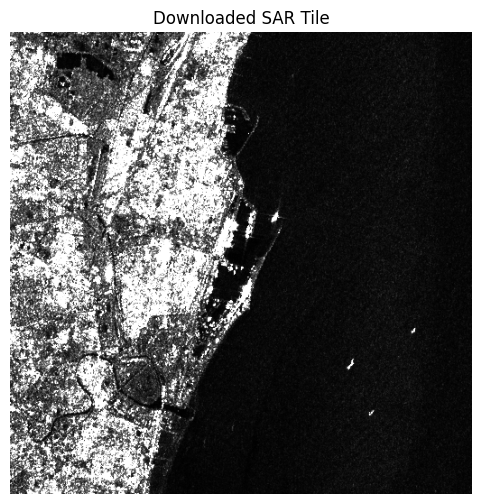


Running prediction...

Prediction: NO OIL SPILL
Confidence: 100.00%
(No-Spill=100.00%, Spill=0.00%)


('NO OIL SPILL', 1.0)

In [31]:
import matplotlib.pyplot as plt
from PIL import Image

def run_live_detection(bbox, filename="live_sar.png"):
    # 1. Download the SAR tile
    tile = download_sar_tile(bbox, filename)

    if tile is None:
        print("Tile download failed.")
        return

    # 2. Display the image
    img = Image.open(tile)
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap="gray")
    plt.title("Downloaded SAR Tile")
    plt.axis("off")
    plt.show()

    # 3. Predict
    print("\nRunning prediction...")
    label, confidence = predict_oil_spill(tile)
    return label, confidence

bbox = [80.25, 13.05, 80.35, 13.15]   # Chennai coast example
run_live_detection(bbox)


In [ ]:
bbox = [80.25, 13.05, 80.35, 13.15]   # Chennai coast example
run_live_detection(bbox)

### Example 1: San Francisco Coast

SAR Tile downloaded ✔: live_sar.png


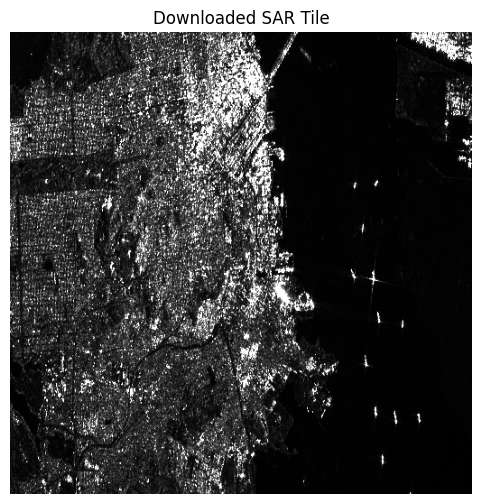


Running prediction...

Prediction: NO OIL SPILL
Confidence: 100.00%
(No-Spill=100.00%, Spill=0.00%)


('NO OIL SPILL', 1.0)

In [32]:
bbox = [-122.5, 37.7, -122.3, 37.8] # San Francisco coast example
run_live_detection(bbox)

### Example 2: Gulf of Mexico (near New Orleans)

SAR Tile downloaded ✔: live_sar.png


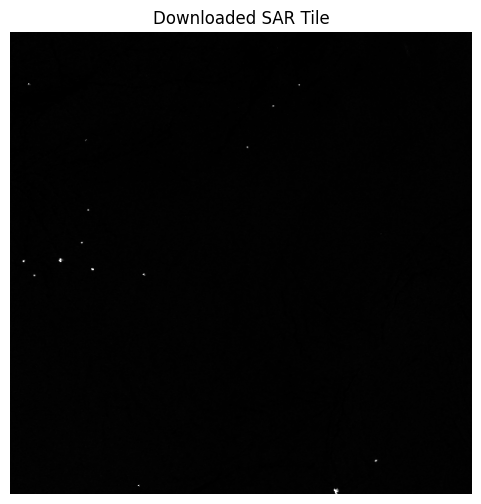


Running prediction...

Prediction: NO OIL SPILL
Confidence: 100.00%
(No-Spill=100.00%, Spill=0.00%)


('NO OIL SPILL', 1.0)

In [33]:
bbox = [-90.0, 29.0, -89.8, 29.2] # Gulf of Mexico example
run_live_detection(bbox)

### Example 3: Mediterranean Sea (near Sicily)

SAR Tile downloaded ✔: live_sar.png


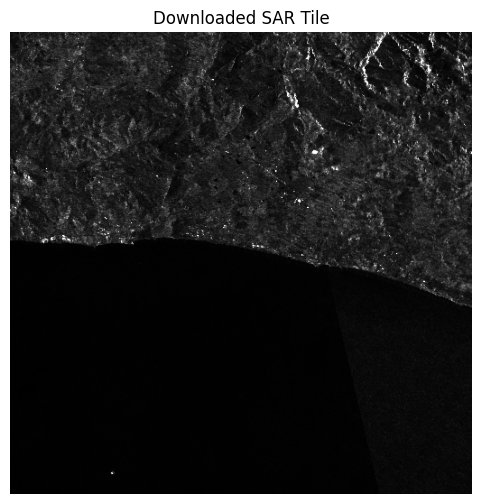


Running prediction...

Prediction: NO OIL SPILL
Confidence: 100.00%
(No-Spill=100.00%, Spill=0.00%)


('NO OIL SPILL', 1.0)

In [34]:
bbox = [14.0, 37.0, 14.2, 37.2] # Mediterranean Sea example
run_live_detection(bbox)